In [2]:
import xarray as xr
from dask.diagnostics.progress import ProgressBar

In [ ]:
da = xr.open_zarr('../data/intermediate/evp_1200itr_long.zarr')

def lat_filter(x: xr.DataArray, threshold):
    mask = x.lat.values >= threshold if threshold > 0 else x.lat.values <= threshold
    return x.isel(z=mask)

with ProgressBar():
    print("masking arctic")
    arctic = lat_filter(da, 80)
    print("saving to zarr")
    arctic = arctic.drop_encoding()
    arctic.to_zarr('../data/processed/arctic/80deg.zarr', mode='w', align_chunks=True, zarr_format=2)

    #print("antarctic mask")
    #antarctic = lat_filter(da, -50)
    #print(" saving to zarr")
    #antarctic.to_zarr('../data/processed/full_antarctic.zarr', mode='w', zarr_format=2, align_chunks=True)


masking arctic
[########################################] | 100% Completed | 416.88 ms
saving to zarr
[########################################] | 100% Completed | 6.02 ss
[########################################] | 100% Completed | 281.22 s
[########################################] | 100% Completed | 6.17 ss
[########################################] | 100% Completed | 284.32 s
[########################################] | 100% Completed | 13m 59s


In [4]:
month_subsets = [1]
arctic = xr.open_zarr('../data/processed/arctic/80deg.zarr')

with ProgressBar():
    for month_subset in month_subsets:
        print(f"subsetting to max month {month_subset}")
        mask = (arctic.time_features.dt.month.values <= month_subset)
        arctic_subset = arctic.isel(z=mask)
        arctic_subset.to_zarr(f'../data/processed/arctic/{month_subset}.zarr', mode='w', align_chunks=True, zarr_format=2)

subsetting to max month 1
[########################################] | 100% Completed | 103.98 ms
[########################################] | 100% Completed | 31.21 s
[########################################] | 100% Completed | 600.26 ms
[########################################] | 100% Completed | 637.57 ms
[########################################] | 100% Completed | 26.79 s


In [5]:
jan = xr.open_zarr('../data/processed/arctic/jan.zarr').load()
jan

<xarray.Dataset> Size: 105MB
Dimensions:        (feature: 10, z: 1092139, label: 2)
Coordinates:
  * feature        (feature) <U7 280B 'siconc' 'sithic' ... 'sidive' 'sishea'
  * label          (label) <U6 48B 'sivelv' 'sivelu'
    lat            (z) float32 4MB 80.01 80.02 80.03 80.04 ... 80.27 80.16 80.05
    lon            (z) float32 4MB 160.1 160.8 161.4 162.1 ... 73.0 73.0 73.0
    pair           (z) int64 9MB 0 0 0 0 0 0 0 0 0 ... 46 46 46 46 46 46 46 46
    time_features  (z) object 9MB 1976-01-01 00:15:00 ... 1976-01-01 23:15:00
    time_labels    (z) object 9MB 1976-01-01 00:45:00 ... 1976-01-01 23:45:00
    x              (z) int64 9MB 373 374 375 376 377 ... 1146 1147 1148 1149
    y              (z) int64 9MB 1119 1119 1119 1119 ... 1205 1205 1205 1205
Dimensions without coordinates: z
Data variables:
    features       (feature, z) float32 44MB 0.997 0.997 ... 6.018e-07 5.446e-07
    labels         (label, z) float32 9MB 0.0331 0.03183 ... -0.06292 -0.0627

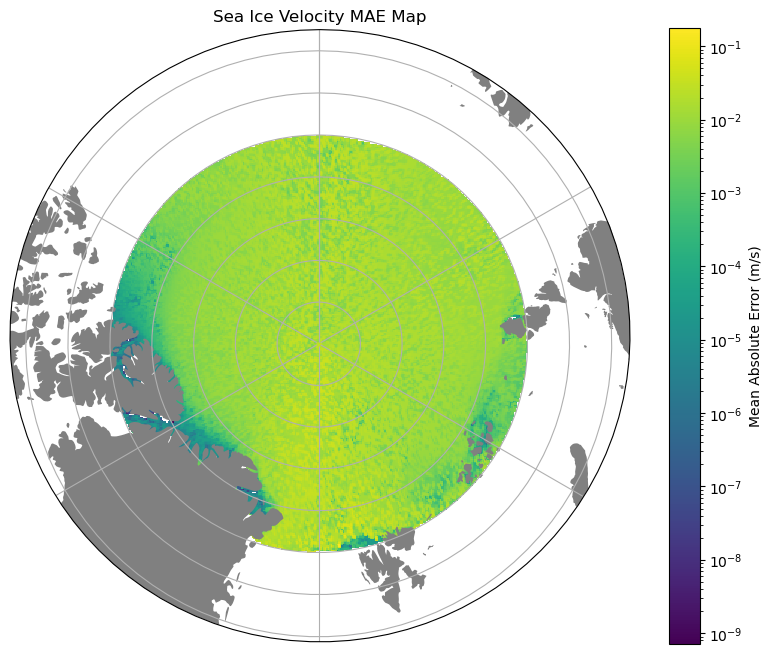

: 

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.colors as colors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from scipy.interpolate import griddata
from scipy.spatial import cKDTree

da = xr.open_zarr('../data/processed/arctic/80deg.zarr')

diff = np.abs((da.features.loc["sivelv"] - da.labels.loc["sivelv"]).values)[:100000]
lat = da.coords['lat'].values[:100000]
lon = da.coords['lon'].values[:100000]

projection = ccrs.NorthPolarStereo()
extent = [-180, 180, 75, 90]

# Source coord system is lon/lat
src_crs = ccrs.PlateCarree()

# Transform to meters
coords_proj = projection.transform_points(src_crs, lon, lat)
x_points = coords_proj[:, 0]
y_points = coords_proj[:, 1]

grid_x_2d, grid_y_2d = np.meshgrid(
np.linspace(-4000000, 4000000, 1000),
np.linspace(-4000000, 4000000, 1000)
)

grid_interpolated = griddata(
(x_points, y_points),
diff,
(grid_x_2d, grid_y_2d),
method='linear'
)

# Mask points that are threshold_meters from any datapoint
threshold_meters = 50000

tree = cKDTree(np.column_stack((x_points, y_points)))
grid_pixels = np.column_stack((grid_x_2d.ravel(), grid_y_2d.ravel()))
dist, _ = tree.query(grid_pixels)
dist = dist.reshape(grid_x_2d.shape)
grid_interpolated[dist > threshold_meters] = np.nan

# Create plot and add coastlines
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=projection)
ax.set_extent(extent, src_crs)
ax.add_feature(cfeature.LAND, zorder=2, facecolor='gray')
#ax.coastlines(resolution='110m', zorder=2)
ax.gridlines()

# Create circular boundary
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

mesh = ax.pcolormesh(
    grid_x_2d, grid_y_2d, 
    grid_interpolated,
    transform=projection,
    norm=colors.LogNorm(),
    cmap='viridis',
    shading='auto'
)

plt.colorbar(mesh, ax=ax, label='Mean Absolute Error (m/s)')
plt.title("Sea Ice Velocity MAE Map")
plt.show()